In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [3]:
root_path = "C:/Univ/ESIB/deuxieme cce 2/mdp/PV03" 
categories_paths = os.listdir(root_path)
categories_paths = [os.path.join(root_path, cat_path) for cat_path in categories_paths]

In [4]:
for cat_path in categories_paths:
    for _, _, files in os.walk(cat_path):
        print("{}: {}".format(cat_path, len(files)))

C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\PV03_Ground_Cropland: 1718
C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\PV03_Ground_Grassland: 234
C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\PV03_Ground_SalineAlkali: 704
C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\PV03_Ground_Shrubwood: 238
C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\PV03_Ground_WaterSurface: 1250
C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\PV03_Rooftop: 472


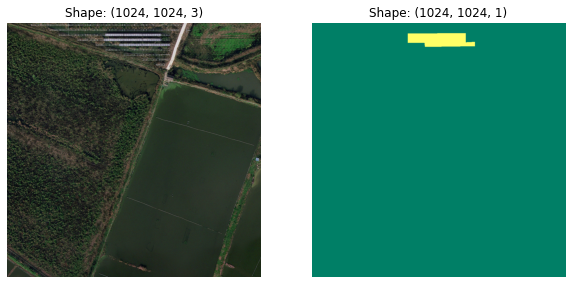

In [5]:
image_path = 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03/PV03_Ground_Cropland/PV03_314875_1196456.bmp'
mask_path = 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03/PV03_Ground_Cropland/PV03_314875_1196456_label.bmp'
image = plt.imread(image_path)
mask = np.expand_dims(plt.imread(mask_path), axis=(-1))
image_shape = image.shape
mask_shape = mask.shape

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

axes[0].imshow(image)
axes[0].set_title('Shape: ' + str(image_shape))

axes[1].imshow(mask, cmap="summer")
axes[1].set_title('Shape: ' + str(mask_shape))

[ax.axis("off") for ax in axes]
plt.show()

In [6]:
images_paths = []
for cat_path in categories_paths:
    for root, _, files in os.walk(cat_path):
        cd_images = [os.path.join(root, file) for file in files]
        [images_paths.append(img) for img in cd_images]
images_paths = sorted(images_paths)
images_paths[:6]

['C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\\PV03_Ground_Cropland\\PV03_314875_1196456.bmp',
 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\\PV03_Ground_Cropland\\PV03_314875_1196456_label.bmp',
 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\\PV03_Ground_Cropland\\PV03_314902_1196424.bmp',
 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\\PV03_Ground_Cropland\\PV03_314902_1196424_label.bmp',
 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\\PV03_Ground_Cropland\\PV03_314902_1196456.bmp',
 'C:/Univ/ESIB/deuxieme cce 2/mdp/PV03\\PV03_Ground_Cropland\\PV03_314902_1196456_label.bmp']

In [7]:
n_images = len(images_paths)
new_size = (256, 256)
images_idx = range(0, n_images, 2)
train_idx, test_idx = train_test_split(images_idx, test_size=0.15)

In [8]:
def train_dataset_generator():
    for i in train_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i]), dtype=tf.float32) / 255.0
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1]), axis=(-1)),
                dtype=tf.float32,
            )
            / 255.0
        )

        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)

        yield image, mask

def test_dataset_generator():
    for i in test_idx:
        image = (
            tf.convert_to_tensor(plt.imread(images_paths[i]), dtype=tf.float32) / 255.0
        )
        mask = (
            tf.convert_to_tensor(
                np.expand_dims(plt.imread(images_paths[i + 1]), axis=(-1)),
                dtype=tf.float32,
            )
            / 255.0
        )

        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)

        yield image, mask

In [9]:
train_dataset = tf.data.Dataset.from_generator(
    train_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)

test_dataset = tf.data.Dataset.from_generator(
    test_dataset_generator,
    output_signature=(
        tf.TensorSpec(shape=(*new_size, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(*new_size, 1), dtype=tf.float32),
    ),
)

In [10]:
def show_images(images, titles=None):
    if not titles:
        titles = [img.shape for img in images]
    fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(10, 30))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="summer")
        ax.set_title(titles[i])
        ax.axis("off")
    plt.show()

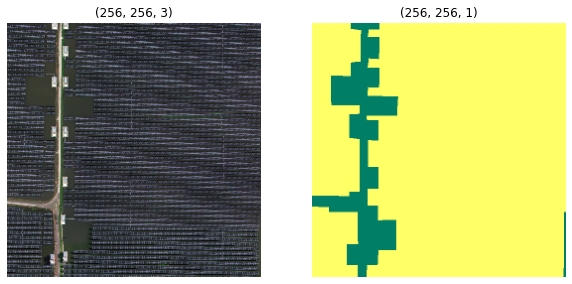

In [11]:
for item in train_dataset.take(1):
    show_images(item)

In [12]:
os.environ["SM_FRAMEWORK"] = "tf.keras"
load_model = True
backbone = 'resnet50'
batch_size = 16

import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [13]:
backbone_preprocess = sm.get_preprocessing(backbone)
preprocess_fn = lambda x, y: (backbone_preprocess(x), y)

train_dataset = train_dataset.map(preprocess_fn)

In [14]:
def is_test(x, _):
    return x % 4 == 0

def is_train(x, y):
    return not is_test(x, y)


recover = lambda x, y: y

valid_dataset = train_dataset.enumerate().filter(is_test).map(recover).batch(batch_size)

train_dataset = train_dataset.enumerate().filter(is_train).map(recover).batch(batch_size)

In [15]:
model = sm.Unet(
    backbone,
    classes=1,
    encoder_weights="imagenet",
    encoder_freeze=True,
)
model.compile("Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

In [16]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0:
            for item in train_dataset.unbatch().shuffle(1).take(1):
                image = item[0]
                mask_4d = self.model.predict(np.expand_dims(image, axis=(0)))
                mask = np.squeeze(mask_4d, axis=0)
                show_images((image, mask))

display_cb = DisplayCallback()
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights='True')

In [17]:
if load_model:
    model_path = "C:/Univ/ESIB/deuxieme cce 2/mdp/code/model_unet-mobilnetv2.h5"
    history_path = "C:/Univ/ESIB/deuxieme cce 2/mdp/code/history_unet-mobilnetv2.csv"
    model = keras.models.load_model(
        model_path,
        custom_objects={
            "binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss,
            "iou_score": sm.metrics.iou_score,
        },
    )
    history = pd.read_csv(history_path)
else:
    with tf.device("/device:GPU:0"):
        history = model.fit(
            train_dataset,
            batch_size=batch_size,
            epochs=100,
            validation_data=valid_dataset,
            callbacks=[display_cb, early_stopping_cb],
        )
    history = pd.DataFrame.from_dict(history.history)

    history.to_csv("history_unet-mobilnetv2.csv", index=False)
    model.save("model_unet-mobilnetv2.h5")

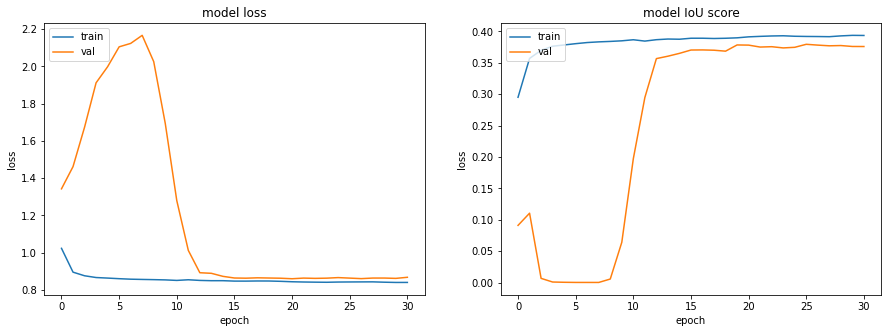

In [18]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history['iou_score'])
plt.plot(history['val_iou_score'])
plt.title('model IoU score')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 1s/step


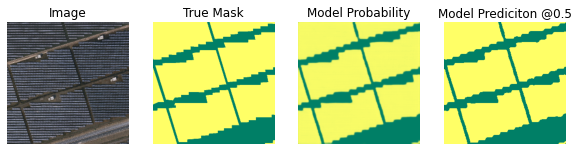

1/1 [==============================] - 0s 238ms/step


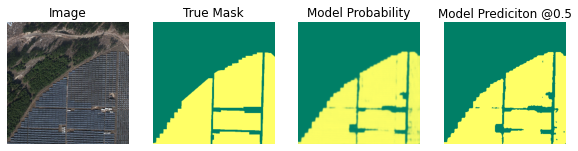

1/1 [==============================] - 0s 222ms/step


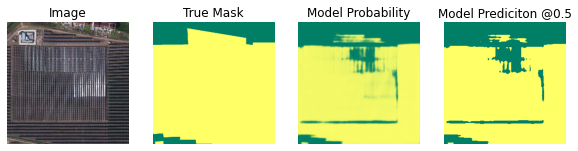

1/1 [==============================] - 0s 218ms/step


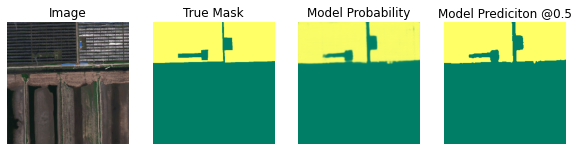

1/1 [==============================] - 0s 219ms/step


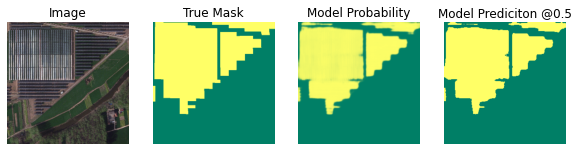

1/1 [==============================] - 0s 220ms/step


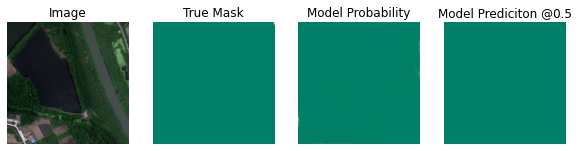

1/1 [==============================] - 0s 386ms/step


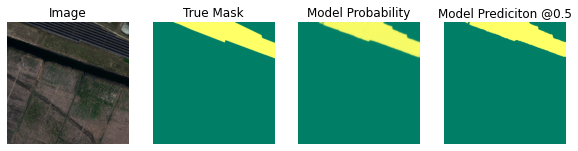

1/1 [==============================] - 0s 369ms/step


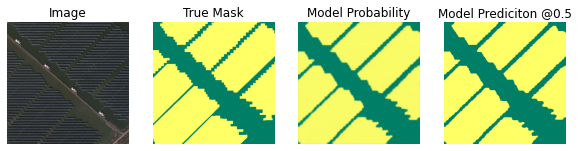

1/1 [==============================] - 0s 240ms/step


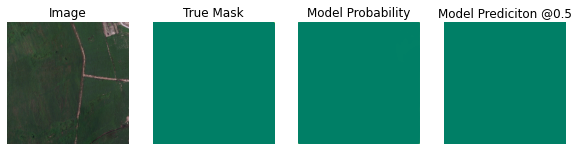

1/1 [==============================] - 0s 218ms/step


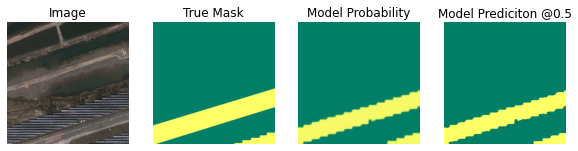

In [19]:
threshold = 0.5

for item in test_dataset.shuffle(10).take(10):
        image = item[0]
        true_mask = item[1]
        mask_4d = model.predict(np.expand_dims(image, axis=(0)))
        pred_mask_proba = np.squeeze(mask_4d, axis=0)
        pred_mask = np.where(pred_mask_proba > threshold, 1, 0)
        
        show_images((image, true_mask, pred_mask_proba, pred_mask), ["Image", "True Mask", "Model Probability", "Model Prediciton @0.5"])

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image

# Define the path to the directory containing the new images
test_images_dir = "C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/images"
output_masks_dir = "C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/masks"  # Directory to save the masks

# Threshold for converting probabilities to binary mask
threshold = 0.5

# Create the output directory if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)

# Iterate over the images in the folder
for filename in os.listdir(test_images_dir):
    # Load and preprocess the image
    image_path = os.path.join(test_images_dir, filename)
    img = keras_image.load_img(image_path, target_size=(256, 256))
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict mask using the model
    pred_mask_proba = model.predict(img_array)[0]  # Extract first (and only) prediction
    pred_mask = np.where(pred_mask_proba > threshold, 1, 0)

    # Plot the predicted mask
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.axis('off')

    # Save the predicted mask as an image
    output_mask_path = os.path.join(output_masks_dir, filename.replace(".jpg", "_mask.png"))
    plt.savefig(output_mask_path, bbox_inches='tight', pad_inches=0)

    plt.close()  # Close the plot to release memory


In [20]:
model.evaluate(test_dataset.batch(batch_size))

22/22 [==============================] - 67s 3s/step - loss: 0.8693 - iou_score: 0.3837


[0.8693126440048218, 0.3837289810180664]

In [23]:
# Save model weights
model.save_weights('model_weights.h5')

# Save model configuration (architecture)
with open('model_config.json', 'w') as f:
    f.write(model.to_json())


In [24]:
# Save model configuration as .config file
with open('model_config.config', 'w') as f:
    f.write(model.to_json())


In [ ]:
# from tensorflow.keras.models import model_from_json

# # Load model configuration
# with open('model_config.json', 'r') as f:
#     model_config = f.read()

# # Reconstruct model from configuration
# model = model_from_json(model_config)

# # Load model weights
# model.load_weights('model_weights.h5')


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm

model_path = "C:/esib/code/model_unet-mobilnetv2.h5"
history_path = "C:/esib/code/history_unet-mobilnetv2.csv"
model = keras.models.load_model(
    model_path,
    custom_objects={
        "binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss,
        "iou_score": sm.metrics.iou_score,
    },
)
history = pd.read_csv(history_path)

# Define the path to the directory containing the new images
test_images_dir = "C:/esib/boundingbox/images"
output_masks_dir = "C:/esib/boundingbox/masks"  # Directory to save the masks

# Threshold for converting probabilities to binary mask
threshold = 0.5

# Create the output directory if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)

# Iterate over the images in the folder
for filename in os.listdir(test_images_dir):
    # Load and preprocess the image
    image_path = os.path.join(test_images_dir, filename)
    img = keras_image.load_img(image_path, target_size=(512, 512))
    img_array = keras_image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Predict mask using the model
    pred_mask_proba = model.predict(img_array)[0]  # Extract first (and only) prediction
    pred_mask = np.where(pred_mask_proba > threshold, 1, 0)

    # Plot the predicted mask
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.axis('off')

    # Save the predicted mask as an image
    output_mask_path = os.path.join(output_masks_dir, filename.replace(".bmp", "_mask.png"))
    plt.savefig(output_mask_path, bbox_inches='tight', pad_inches=0)

    # Clear current plot to prevent overlapping images
    plt.clf()
    plt.close()  # Close the plot to release memory


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
import cv2

model_path = "C:/esib/code/model_unet-mobilnetv2.h5"
history_path = "C:/esib/code/history_unet-mobilnetv2.csv"
model = keras.models.load_model(
    model_path,
    custom_objects={
        "binary_crossentropy_plus_jaccard_loss": sm.losses.bce_jaccard_loss,
        "iou_score": sm.metrics.iou_score,
    },
)
history = pd.read_csv(history_path)

# Define the path to the directory containing the new images
test_images_dir = "C:/esib/boundingbox/images"
output_masks_dir = "C:/esib/boundingbox/masks"  # Directory to save the masks
output_bb_dir = "C:/esib/boundingbox/bb"  # Directory to save the bounding box annotations

# Threshold for converting probabilities to binary mask
threshold = 0.3

# Create the output directory if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)
os.makedirs(output_bb_dir, exist_ok=True)

# Function to process mask and generate bounding box annotations
def process_mask(mask_path, output_file):
    # Read the mask image
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Open the output file for writing annotations
    with open(output_file, 'w') as f:
        for contour in contours:
            # Calculate bounding box coordinates
            x, y, w, h = cv2.boundingRect(contour)
            # Normalize coordinates
            image_width, image_height = mask.shape[1], mask.shape[0]
            center_x = (x + w / 2) / image_width
            center_y = (y + h / 2) / image_height
            normalized_width = w / image_width
            normalized_height = h / image_height
            # Write annotation to file in YOLO format
            f.write(f"0 {center_x} {center_y} {normalized_width} {normalized_height}\n")  # Assuming class label is 0

# Iterate over the images in the folder
for filename in os.listdir(test_images_dir):
    if filename.lower().endswith(('.bmp', '.jpg')):
        # Load and preprocess the image
        image_path = os.path.join(test_images_dir, filename)
        img = keras_image.load_img(image_path, target_size=(256, 256))
        img_array = keras_image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Predict mask using the model
        pred_mask_proba = model.predict(img_array)[0]  # Extract first (and only) prediction
        pred_mask = np.where(pred_mask_proba > threshold, 1, 0)

        # Plot the predicted mask
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.axis('off')

        # Save the predicted mask as an image
        output_mask_path = os.path.join(output_masks_dir, os.path.splitext(filename)[0] + "_mask.png")
        plt.savefig(output_mask_path, bbox_inches='tight', pad_inches=0)

        plt.close()  # Close the plot to release memory

        # Process the generated mask to generate bounding box annotations
        output_bb_file = os.path.join(output_bb_dir, os.path.splitext(filename)[0] + ".txt")
        process_mask(output_mask_path, output_bb_file)


In [ ]:
import os
import cv2

def read_annotations_from_file(annotation_file):
    annotations = []
    with open(annotation_file, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split()
            class_label = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            normalized_width = float(parts[3])
            normalized_height = float(parts[4])
            annotations.append((class_label, x_center, y_center, normalized_width, normalized_height))
    return annotations

def visualize_annotations(image_path, annotations):
    # Load the image
    image = cv2.imread(image_path)

    # Draw bounding boxes on the image
    for annotation in annotations:
        class_label, x_center, y_center, normalized_width, normalized_height = annotation
        
        # Convert YOLO coordinates to pixel coordinates
        image_height, image_width, _ = image.shape
        x = int((x_center - normalized_width / 2) * image_width)
        y = int((y_center - normalized_height / 2) * image_height)
        width = int(normalized_width * image_width)
        height = int(normalized_height * image_height)
        
        # Draw bounding box rectangle
        color = (0, 255, 0)  # Green color for bounding boxes
        cv2.rectangle(image, (x, y), (x + width, y + height), color, 2)
        
        # Add class label text
        label_text = f"Class: {class_label}"
        cv2.putText(image, label_text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image with bounding boxes
    cv2.imshow("Image with Bounding Boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Paths
test_images_dir = "C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/images"
output_masks_dir = "C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/masks"
output_bb_dir = "C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/bb"

# Iterate over the images in the folder
for filename in os.listdir(test_images_dir):
    # Load image
    image_path = os.path.join(test_images_dir, filename)
    
    # Construct the corresponding annotation file path
    annotation_file = os.path.join(output_bb_dir, os.path.splitext(filename)[0] + ".txt")
    
    # Check if annotation file exists
    if os.path.isfile(annotation_file):
        # Read annotations from file
        annotations = read_annotations_from_file(annotation_file)
        
        # Visualize annotations on the image
        visualize_annotations(image_path, annotations)
    else:
        print(f"No annotation file found for image: {filename}")


In [31]:
import cv2
import numpy as np

def visualize_annotations(image_path, mask_path):
    # Load the image and mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    # Resize the mask to match the image dimensions
    mask = cv2.resize(mask, (image.shape[1], image.shape[0]))

    # Check if the image and mask are loaded successfully
    if image is None:
        print("Error: Failed to load the image.")
        return None, None
    if mask is None:
        print("Error: Failed to load the mask.")
        return None, None

    # Print image and mask dimensions
    print("Image dimensions:", image.shape)
    print("Mask dimensions:", mask.shape)

    # Check if the mask contains non-zero pixel values
    if np.count_nonzero(mask) == 0:
        print("Warning: The mask does not contain any non-zero pixel values.")

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to store bounding box coordinates
    bounding_boxes = []

    # Draw bounding boxes that follow the shape of the contours
    for contour in contours:
        # Approximate the contour to get a simpler polygon
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        
        # Get the bounding box coordinates
        x, y, w, h = cv2.boundingRect(approx)

        # Append bounding box coordinates to the list
        bounding_boxes.append((x, y, x + w, y + h))

        # Draw the bounding box polygon
        cv2.polylines(image, [approx], True, (0, 255, 0), 2)
    
    # Display the image with non-rectangular bounding boxes
    cv2.imshow("Image with Non-Rectangular Bounding Boxes", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    # Return the list of bounding box coordinates and the image
    return bounding_boxes, image

# Example usage
image_path = 'C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/images/ezgif-6-0082391d51.jpg'
mask_path = 'C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/masks/ezgif-6-0082391d51_mask.png'

bounding_boxes, image = visualize_annotations(image_path, mask_path)
print("Bounding boxes:", bounding_boxes)


Image dimensions: (810, 810, 3)
Mask dimensions: (810, 810)
Bounding boxes: [(252, 106, 610, 293)]


In [35]:
import cv2

def get_top_left_coordinates(bounding_boxes, image):
    # Check if the image is loaded successfully
    if image is None:
        print("Error: Failed to load the image.")
        return None
    
    # Initialize list to store top-left corner coordinates
    top_left_coordinates = []
    
    # Draw points on the image at the top-left corners of bounding boxes
    for box in bounding_boxes:
        x, y, _, _ = box  # Extract the bounding box coordinates
        top_left_coordinates.append((x, y))  # Append top-left corner coordinates to the list
        cv2.circle(image, (x, y), 5, (0, 0, 255), -1)  # Draw a red point at the top-left corner
    
    # Display the image with points
    cv2.imshow("Image with Top-Left Corner Points", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    
    # Return the list of top-left corner coordinates
    return top_left_coordinates

# Example usage
image_path = 'C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/images/ezgif-6-0082391d51.jpg'
mask_path = 'C:/Univ/ESIB/deuxieme cce 2/mdp/boundingbox/masks/ezgif-6-0082391d51_mask.png'

bounding_boxes, image = visualize_annotations(image_path, mask_path)
print("Bounding boxes:", bounding_boxes)

top_left_coordinates = get_top_left_coordinates(bounding_boxes, image)
print("Top-left corner coordinates:", top_left_coordinates)

for box in bounding_boxes:
    x, y, _, _ = box  # Extract the bounding box coordinates
    print("Point coordinates:", (x, y))  # Print the point coordinates for verification
    top_left_coordinates.append((x, y))  # Append top-left corner coordinates to the list
    cv2.circle(image, (x, y), 5, (0, 0, 255), -1)  # Draw a red point at the top-left corner



Image dimensions: (810, 810, 3)
Mask dimensions: (810, 810)
Bounding boxes: [(252, 106, 610, 293)]
Top-left corner coordinates: [(252, 106)]
Point coordinates: (252, 106)
